# Dépenses de consommation trimestrielles des ménages

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_pca_correlation_graph
import os

%matplotlib inline

cwd = os.getcwd()

## Data Management
### Import des données

In [2]:
os.chdir(cwd+'/Ressources')
conso = pd.read_csv('Consommation.csv',sep=';')
conso_fonction = pd.read_csv('Consommation par fonction.csv',sep=';')
os.chdir(cwd)

### Élimination des lignes et colonnes indésirables

In [3]:
conso = conso.set_index('Libellé').drop('idBank').drop('Période').drop('Codes',axis=1).astype('float64')
conso_fonction = conso_fonction.set_index('Libellé').drop('idBank').drop('Période').filter(like='Dépenses').astype('float64')

### Simplification des noms des features

In [4]:
renaming = {}
for elt in conso_fonction.columns:
    renaming[elt]=elt.lstrip('Dépense de consommation des ménages - ').rstrip('Série CVS-CJO').rstrip('Volume aux prix de l\'année précédente chaînés').rstrip(' -')

conso_fonction = conso_fonction.rename(renaming,axis='columns')

conso = conso.rename({'Dépenses de consommation des ménages - Total - Volume aux prix de l\'année précédente chaînés - Série CVS-CJO':'Total'},axis='columns')

### Séparations des comptes qui se recoupent

In [5]:
conso_durabilite = pd.DataFrame()
conso_durabilite['Biens'] = pd.Series(conso_fonction.pop('Biens'))
conso_durabilite['Services'] = pd.Series(conso_fonction.pop('Services'))

### Calcul des variation de trimestre en trimestre

Par variation nous entendons: variation = (consommation du trimestre actuel/consommation du trimestre précédent) - 1

In [6]:
variations_conso_fonction = pd.DataFrame()

for column in conso_fonction.columns:
    potiteliste = []
    for i  in range(len(conso_fonction[column])-1):
        potiteliste.append(conso_fonction[column][i+1]/conso_fonction[column][i] - 1)
    variations_conso_fonction[column] = pd.Series(potiteliste)
    
variations_conso = pd.DataFrame()
potiteliste = []
for i in range(len(conso)-1):
    potiteliste.append(conso['Total'][i+1]/conso['Total'][i] - 1)
variations_conso['Total'] = pd.Series(potiteliste)

Pour résumer le data management:
* conso contient la variable cible: la dépense de consommation finale des ménages trimestrielle
* conso_fonction contient les fonctions de consommation
* variations_conso contient les variations des dépenses de consommation finale, de trimestre en trimestre
* variations_conso_fonction fait de même pour les fonctions de consommation

## Graphiques

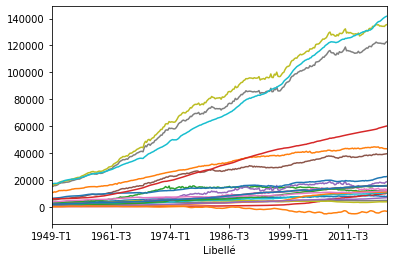

In [7]:
for column in conso_fonction.columns:
    conso_fonction[column].iloc[::-1].plot()

## ACP

In [8]:
pca = PCA()
pca.fit_transform(variations_conso_fonction)
print(np.around(pca.explained_variance_ratio_,3))

[0.969 0.012 0.005 0.005 0.002 0.002 0.001 0.001 0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]


Text(0.5, 1.0, 'Variance expliquée')

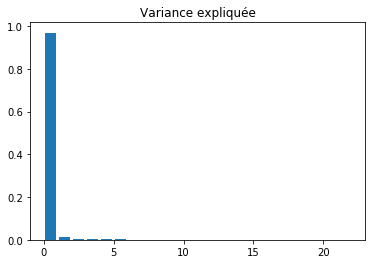

In [9]:
plt.bar(np.arange(len(pca.explained_variance_ratio_))+0.5, pca.explained_variance_ratio_)
plt.title("Variance expliquée")

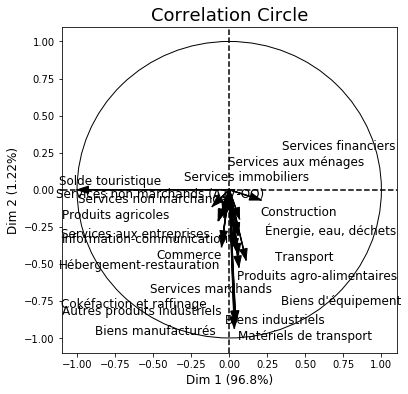

In [10]:
figure, correlation_matrix = plot_pca_correlation_graph(variations_conso_fonction, 
                                                        variations_conso_fonction.columns)

L'ACP est à compléter : comment est composé ce vecteur qui explique 96% de la variance ?

## ANOVA

In [24]:
os.chdir(cwd+'/Ressources')
conso_tri=pd.read_csv('Consommation des ménages trimestrielle.csv',sep=';')
os.chdir(cwd)

In [25]:
conso_tri=conso_tri.set_index('Période').T

In [26]:
for column in conso_tri.columns:
    for i in range(0,18,1):
        conso_tri[column][i]=conso_tri[column][i].replace(',','.')
        conso_tri[column][i]=float(conso_tri[column][i])

### Calcul du poids de chaque catégorie

In [27]:
weights = pd.DataFrame()
for column in conso_tri.columns:
    cat = []
    for i in range(0,18,1):
        cat.append(conso_tri[column][i]/conso_tri[column][17])
    weights[column]= pd.Series(cat)
weights=weights.set_index(conso_tri.index)

In [28]:
t_weights=weights.iloc[:-1,:].T
mean_weights= pd.DataFrame()
for column in t_weights.columns:
    m=[t_weights[column].mean()]
    mean_weights[column]=pd.Series(m)
mean_weights.index=['Poids moyen']

In [29]:
mean_weights.T

,Poids moyen
Produits agricoles,0.029587
"Energie, eau, déchets",0.042214
Produits agro-alimentaires,0.153231
Cokéfaction et raffinage,0.042582
Biens d'équipement,0.030978
Matériels de transport,0.062470
Autres produits industriels,0.144076
Construction,0.014645
Commerce,0.012431
Transport,0.029877


### Year to year variations

In [30]:
t_conso=conso_tri.T

In [31]:
yty_var = pd.DataFrame()
for column in t_conso.columns:
    var=[]
    for i in range(4,len(conso_tri.columns),1):
        var.append((t_conso[column][i]-t_conso[column][i-4])/t_conso[column][i-4])
    yty_var[column]=pd.Series(var)

In [32]:
yty_var=yty_var.set_index(t_conso.index.drop('1990T1').drop('1990T2').drop('1990T3').drop('1990T4')).T

### Variance des variations

In [33]:
t_yty = yty_var.iloc[:-1,:].T
variance= pd.DataFrame()
for column in t_yty.columns:
    v=[]
    s=0
    for i in range(0,len(t_yty[column]),1):
        s= s+ (t_yty[column][i]-t_yty[column].sum())**2
    v.append((1/(len(t_yty[column])))*s)
    variance[column]=pd.Series(v)
variance.index=['Variance de variation']

In [34]:
variance.T

,Variance de variation
Produits agricoles,6.978181
"Energie, eau, déchets",18.321859
Produits agro-alimentaires,8.480389
Cokéfaction et raffinage,9.814771
Biens d'équipement,6.240244
Matériels de transport,6.631205
Autres produits industriels,3.960763
Construction,17.290893
Commerce,9.917489
Transport,20.547509


### Part de la variance

In [35]:
share_of_variance=pd.DataFrame()
for column in variance.columns: 
    p=[]
    s=0
    for i in range(0,17,1):
        s=s+ variance.T['Variance de variation'][i]*mean_weights.T['Poids moyen'][i]
    p.append((variance[column][0]*mean_weights[column][0])/s)
    share_of_variance[column]=pd.Series(p)
share_of_variance.index=['Part de la variation']

In [36]:
share_of_variance.T

,Part de la variation
Produits agricoles,0.017167
"Energie, eau, déchets",0.064309
Produits agro-alimentaires,0.108046
Cokéfaction et raffinage,0.034750
Biens d'équipement,0.016073
Matériels de transport,0.034444
Autres produits industriels,0.047448
Construction,0.021056
Commerce,0.010251
Transport,0.051044
